In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('rgba_mask.png', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (500, 800), interpolation=cv2.INTER_LINEAR)

# Ensure mask is binary
_, image = cv2.threshold(image, 127, 1, cv2.THRESH_BINARY)

In [46]:
def plot(figures):
    # Create subplots
    fig, axs = plt.subplots(1, len(figures), figsize=(4*len(figures), 4))
    
    # Plot the original image
    for i, fig in enumerate(figures):
        axs[i].imshow(fig)
    
    # Remove ticks from the subplots
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Display the subplots
    plt.tight_layout()
    plt.show()

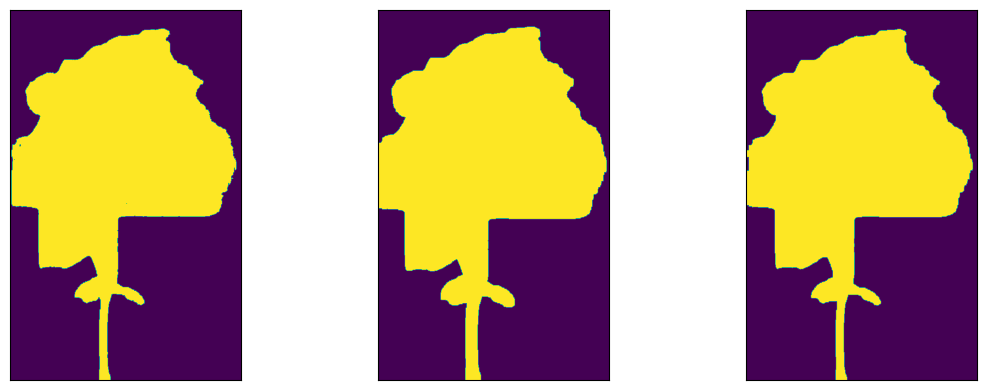

In [47]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10), (5, 5))

dilated = cv2.dilate(image, kernel)
eroded = cv2.erode(dilated, kernel)
plot([image, dilated, eroded])

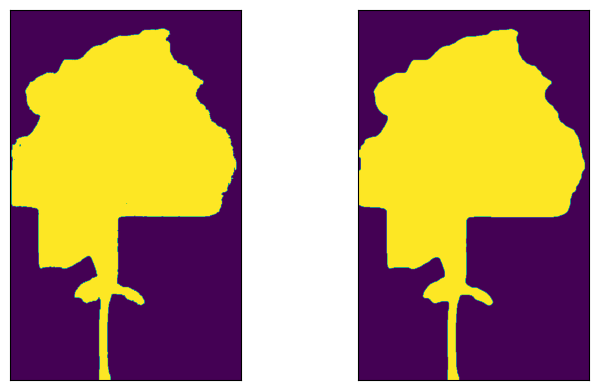

In [51]:
smoothed = cv2.medianBlur(eroded, 7)
plot([image, smoothed])

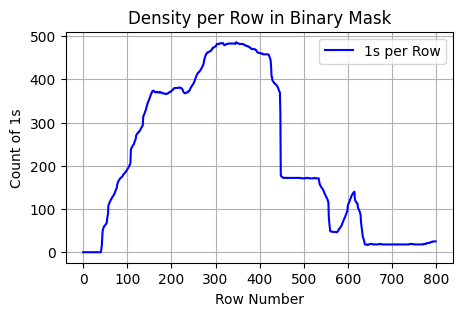

In [52]:
distribution_per_row = np.sum(smoothed, axis=1)

plt.figure(figsize=(5, 3))
plt.plot(distribution_per_row, label='1s per Row', color='blue', linewidth=1.5)
plt.xlabel("Row Number")
plt.ylabel("Count of 1s")
plt.title("Density per Row in Binary Mask")
plt.legend()
plt.grid(True)
plt.show()

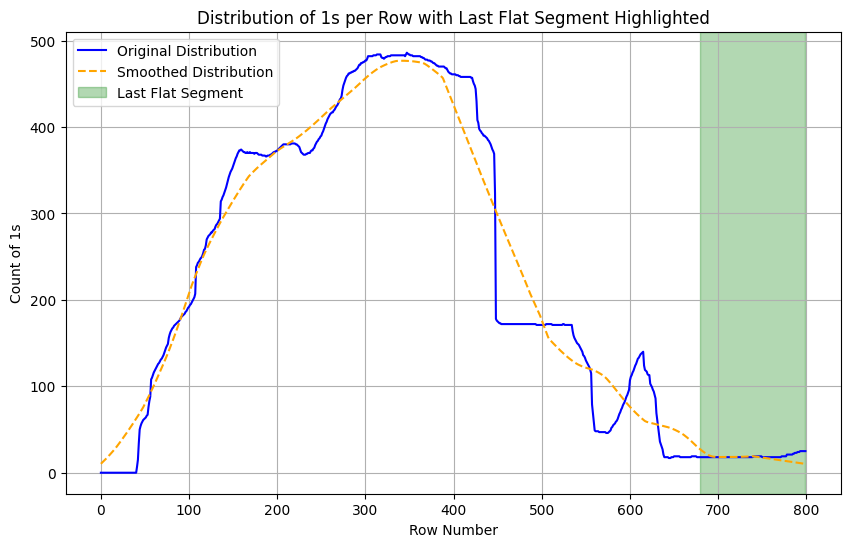

Last flat segment found from row 679 to row 798
679


In [111]:
window_size = 120  # Size of the smoothing window
smoothed_distribution = np.convolve(distribution_per_row, np.ones(window_size)/window_size, mode='same')

# Define a tolerance for flatness (e.g., maximum allowed difference within a segment)
tolerance = 100

start_idx, end_idx = None, None
for i in range(len(smoothed_distribution) - window_size):
    segment = smoothed_distribution[i:i + window_size]
    if np.max(segment) - np.min(segment) <= tolerance:
        start_idx = i  # Start of flat segment
        end_idx = i + window_size - 1  # End of flat segment

# Plot the distribution and highlight the last flat segment
plt.figure(figsize=(10, 6))
plt.plot(distribution_per_row, label="Original Distribution", color="blue", linewidth=1.5)
plt.plot(smoothed_distribution, label="Smoothed Distribution", color="orange", linestyle="--")
if start_idx is not None and end_idx is not None:
    plt.axvspan(start_idx, end_idx, color="green", alpha=0.3, label="Last Flat Segment")

plt.xlabel("Row Number")
plt.ylabel("Count of 1s")
plt.title("Distribution of 1s per Row with Last Flat Segment Highlighted")
plt.legend()
plt.grid(True)
plt.show()

print("Last flat segment found from row", start_idx, "to row", end_idx)
print(start_idx)

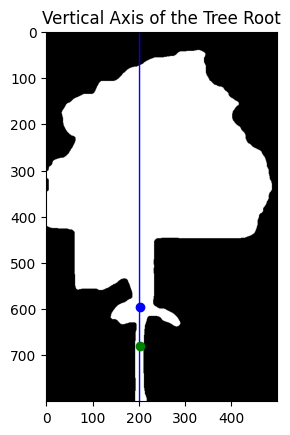

In [116]:
height, width = image.shape
root_region = smoothed[start_idx:, :]
# Find contours in the root region to identify the root area
contours, _ = cv2.findContours(root_region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# If there are multiple contours, choose the largest one (assumed to be the root)
root_contour = max(contours, key=cv2.contourArea)

# Calculate the centroid of the root contour
M = cv2.moments(root_contour)
if M["m00"] != 0:
    cx = int(M["m10"] / M["m00"])  # x-coordinate of the centroid
    cy = int(M["m01"] / M["m00"])  # y-coordinate of the centroid
else:
    cx, cy = 0, 0  # Fallback if area is zero

# Adjust centroid position to the original image coordinates
cy += int(height * 2 / 3)

# Draw the vertical axis on the original image for visualization
output_image = cv2.cvtColor(smoothed * 255, cv2.COLOR_GRAY2BGR)
cv2.line(output_image, (cx, 0), (cx, height), (0, 0, 255), 2)  # Red line for vertical axis

# Display the result
plt.imshow(output_image)
plt.scatter([cx], [cy], color='blue', marker='o')  # Mark centroid for reference
plt.scatter([cx], [start_idx], color='green', marker='o')  # Mark centroid for reference
plt.title("Vertical Axis of the Tree Root")
plt.show()

41
22


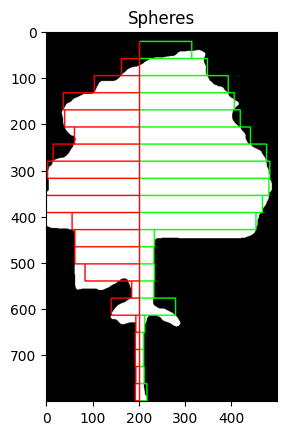

In [130]:
from enum import Enum
STEPS = 20

class policy(Enum):
    EVEN = 1
    DYNAMIC = 2

distribution_per_row = np.sum(smoothed, axis=1)
# Find indices where the array is non-zero
non_zero_indices = np.flatnonzero(distribution_per_row)

# Slice from the first to the last non-zero index
trimmed_array = distribution_per_row[non_zero_indices[0] : non_zero_indices[-1] + 1]
spheres = []

sphere_image = cv2.cvtColor(smoothed * 255, cv2.COLOR_GRAY2BGR)
STEP_POLICY = policy.EVEN
if STEP_POLICY== policy.EVEN:
    step_size = len(trimmed_array) // STEPS
    y_coord = 0
    y_coord_abs = non_zero_indices[-1]
    for idx in range(non_zero_indices[-1], non_zero_indices[0], -step_size):
        left_rad = int(smoothed[idx][0:cx].sum())
        left_point = cx - left_rad
        right_rad = int(smoothed[idx][cx:].sum())
        right_point = cx + right_rad
        spheres.append((y_coord, left_rad, right_rad))
        prev = y_coord_abs
        y_coord += step_size
        y_coord_abs -= step_size
        
        cv2.rectangle(sphere_image, (cx, y_coord_abs), (right_point, prev), (0, 255, 0), 2)
        cv2.rectangle(sphere_image, (left_point, y_coord_abs), (cx, prev), (255, 0, 0), 2)
else:
    y_coord_abs = non_zero_indices[-1]
    it = 0
    while y_coord_abs > non_zero_indices[0] and it < 1000:
        left_rad = int(smoothed[y_coord_abs][0:cx].sum())
        left_point = cx - left_rad
        right_rad = int(smoothed[y_coord_abs][cx:].sum())
        right_point = cx + right_rad
        spheres.append((y_coord, left_rad, right_rad))
        prev = y_coord_abs
        y_coord_abs -= min(left_rad, right_rad)
        
        cv2.rectangle(sphere_image, (cx, y_coord_abs), (right_point, prev), (0, 255, 0), 2)
        cv2.rectangle(sphere_image, (left_point, y_coord_abs), (cx, prev), (255, 0, 0), 2)
        it += 1

print(non_zero_indices[0])  
print(y_coord_abs)

# Display the result
plt.imshow(sphere_image)
plt.title("Spheres")
plt.show()

In [131]:
print(spheres)

[(0, 9, 16), (37, 8, 10), (74, 9, 9), (111, 9, 9), (148, 8, 11), (185, 61, 78), (222, 17, 31), (259, 118, 32), (296, 140, 31), (333, 140, 32), (370, 146, 252), (407, 202, 266), (444, 202, 280), (481, 199, 282), (518, 187, 275), (555, 141, 240), (592, 162, 218), (629, 165, 205), (666, 98, 192), (703, 39, 147), (740, 0, 113)]


In [142]:
heights = []
ls = []
rs = []

for sphere in spheres:
    heights.append(float(sphere[0]))
    ls.append(float(sphere[1]))
    rs.append(float(sphere[2]))

for l in [heights, ls, rs]:
    m = max(l)
    for i, val in enumerate(l):
        l[i] = round(val * 0.5 / m, 2)
    
print(rs)

[0.03, 0.02, 0.02, 0.02, 0.02, 0.14, 0.05, 0.06, 0.05, 0.06, 0.45, 0.47, 0.5, 0.5, 0.49, 0.43, 0.39, 0.36, 0.34, 0.26, 0.2]
